# Andreas Kyratzis Dissertation code notebook

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
df=pd.read_csv('entry-stats-2013-onwards.csv')


## Data Cleaning and Pre-processing

In [3]:
df['TIMESTAMP']=pd.to_datetime(df['TIMESTAMP'])
df=df.sort_values(by='TIMESTAMP')

In [4]:
# data cleaning
start_date='2017-01-01'
mask=(df['TIMESTAMP']>start_date)
df = df.loc[mask]
df = df.dropna(axis=0, subset=['Category1','Category3'])
mask1=(df['Category1']!='\\N')
df = df.loc[mask1]

mask2=(df['Category3']!='\\n')
df = df.loc[mask2]
mask3=(df['Category3']!='auto-out')
df = df.loc[mask3]

In [5]:
df['Category11']=df['Category1'].str.replace(" ","").str.lower().str.replace('assisitvetechenabled','assistivetechenabled')
df['Category31']=df['Category3'].str.replace(" ","").str.lower()
remove_catgories=['default','bn06', 'bn01','override', 'bn07', 'bn02', 'accessstudents','auto-out','associate','reference']
for i in range(len(remove_catgories)):
    mask1=(df['Category11']!=remove_catgories[i])
    df = df.loc[mask1]
df=df.set_index('TIMESTAMP')

## Exploratory Data Analysis

In [6]:
df.head(10)

,Direction,Category1,Category3,Category11,Category31
TIMESTAMP,,,,,
2017-01-01 02:00:00,O,Undergraduate,"School of Business, Management",undergraduate,"schoolofbusiness,management"
2017-01-02 10:01:35,I,Postgraduate Taught,School of Mathematical and Phy,postgraduatetaught,schoolofmathematicalandphy
2017-01-02 10:01:39,I,Postgraduate Taught,School of Mathematical and Phy,postgraduatetaught,schoolofmathematicalandphy
2017-01-02 10:01:43,I,Postgraduate Taught,School of Mathematical and Phy,postgraduatetaught,schoolofmathematicalandphy
2017-01-02 10:01:47,I,Postgraduate Taught,"School of Business, Management",postgraduatetaught,"schoolofbusiness,management"
2017-01-02 10:01:53,I,Postgraduate Taught,"School of Media, Film and Musi",postgraduatetaught,"schoolofmedia,filmandmusi"
2017-01-02 10:01:58,I,Undergraduate,"School of Law, Politics and So",undergraduate,"schooloflaw,politicsandso"
2017-01-02 10:02:05,I,Undergraduate,School of Mathematical and Phy,undergraduate,schoolofmathematicalandphy
2017-01-02 10:02:08,I,Undergraduate,School of Life Sciences,undergraduate,schooloflifesciences


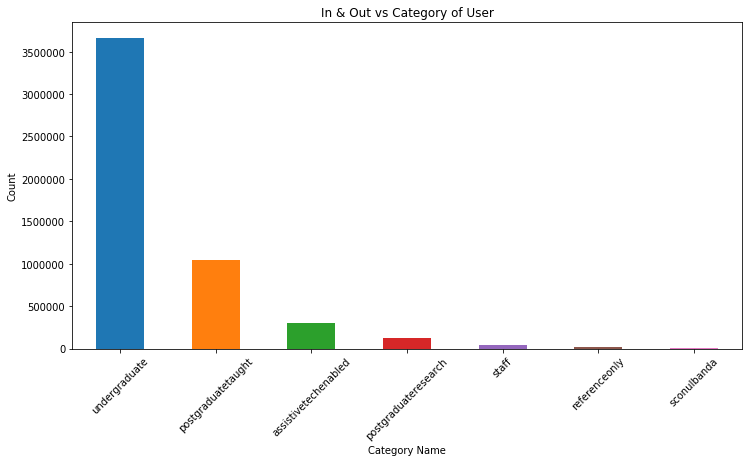

In [7]:
df['Category11'].value_counts()[:7].plot(kind = "bar",figsize = (12,6))
plt.xticks(rotation=45)
plt.title('In & Out vs Category of User')
plt.xlabel('Category Name')
plt.ylabel('Count')
plt.show()

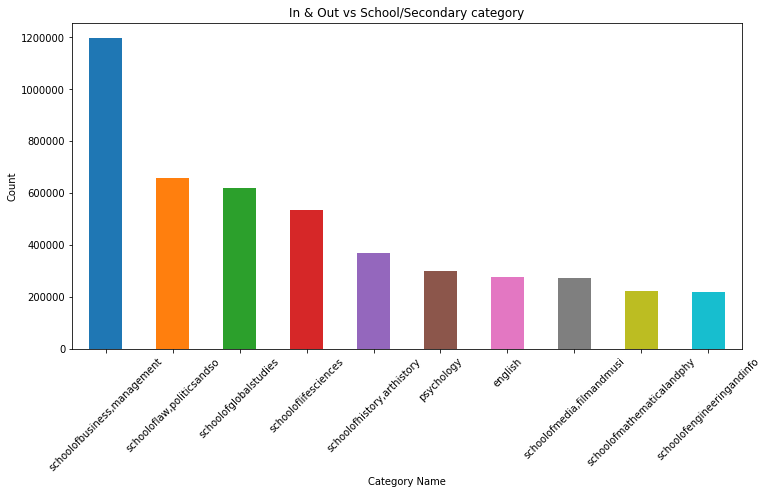

In [8]:
df['Category31'].value_counts()[:10].plot(kind = "bar",figsize = (12,6))
plt.xticks(rotation=45)
plt.title('In & Out vs School/Secondary category')
plt.xlabel('Category Name')
plt.ylabel('Count')
plt.show()

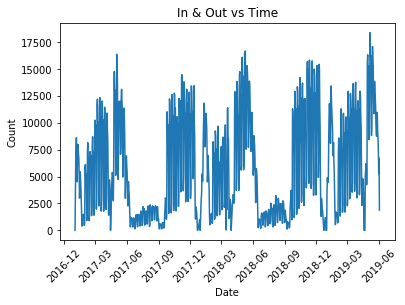

In [9]:
df.groupby(df.index.date).count()['Category11'].plot()
plt.xticks(rotation=45)
plt.title('In & Out vs Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

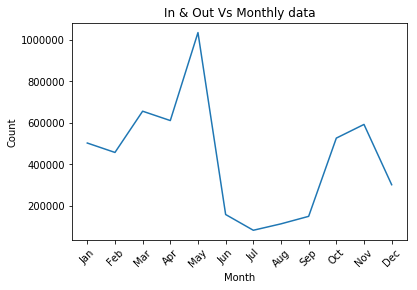

In [10]:
m_data=df.groupby(df.index.month).count()['Category1'].values
plt.plot(np.arange(12),m_data)
plt.xticks(rotation=45)
plt.xticks(np.arange(12), ('Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
plt.title('In & Out Vs Monthly data')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

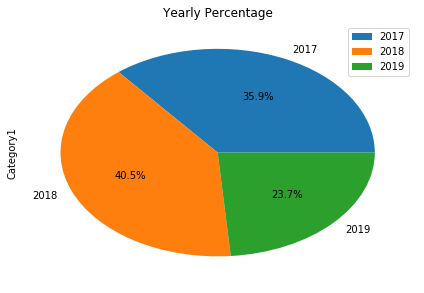

In [11]:
df.groupby(df.index.year).count()['Category1'].plot(kind='pie',autopct='%1.1f%%')
plt.tight_layout()
plt.title('Yearly Percentage')
plt.legend()
plt.show()

In [12]:
df.groupby(df.index.month).count()

,Direction,Category1,Category3,Category11,Category31
TIMESTAMP,,,,,
1,502796,502796,502796,502796,502796
2,457416,457416,457416,457416,457416
3,656190,656190,656190,656190,656190
4,611101,611101,611101,611101,611101
5,1035097,1035097,1035097,1035097,1035097
6,158277,158277,158277,158277,158277
7,82378,82378,82378,82378,82378
8,113290,113290,113290,113290,113290
9,149464,149464,149464,149464,149464


In [13]:
uni_category=df['Category11'].unique()

In [14]:
uni_category

array(['undergraduate', 'postgraduatetaught', 'postgraduateresearch',
       'sconulbanda', 'sconulbandb', 'staff', 'sconulreferenceonly',
       'referenceonlycard', 'librarystaff', 'referenceonly',
       'sconulbandc', 'assistivetechenabled', 'postgraduate',
       'ugextended', 'pgextended', 'alumni', 'research', 'assistivetech'],
      dtype=object)

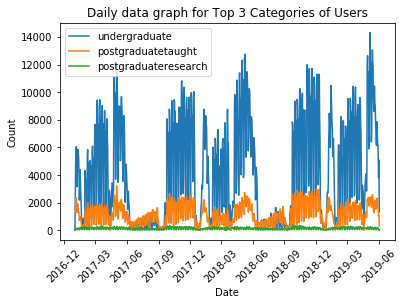

In [15]:
for i in range(3):
    df1=df.loc[df['Category11']==uni_category[i]]
    df1.groupby(df1.index.date).count()['Category11'].plot(label=uni_category[i])
plt.xticks(rotation=45)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily data graph for Top 3 Categories of Users')
plt.show()

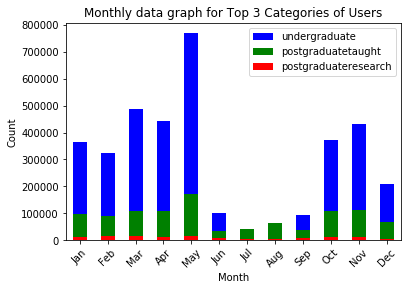

In [16]:
colors=['b','g','r']
for i in range(3):
    df1=df.loc[df['Category11']==uni_category[i]]
    df1.groupby(df1.index.month).count()['Category11'].plot(label=uni_category[i],kind = "bar", color=colors[i])
plt.legend()
plt.xticks(rotation=45)
plt.xticks(np.arange(12), ('Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly data graph for Top 3 Categories of Users')
plt.show()

In [17]:
uni_category3=df['Category31'].unique()

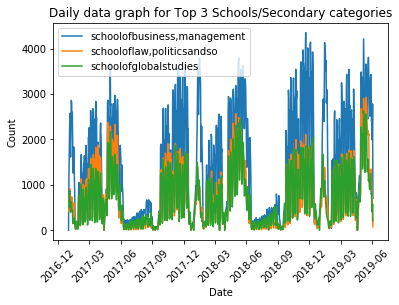

In [18]:
top_3categories=['schoolofbusiness,management','schooloflaw,politicsandso','schoolofglobalstudies']
for i in range(3):
    df3=df.loc[df['Category31']==top_3categories[i]]
    df3.groupby(df3.index.date).count()['Category31'].plot(label=top_3categories[i])
plt.xticks(rotation=45)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily data graph for Top 3 Schools/Secondary categories')
plt.show()

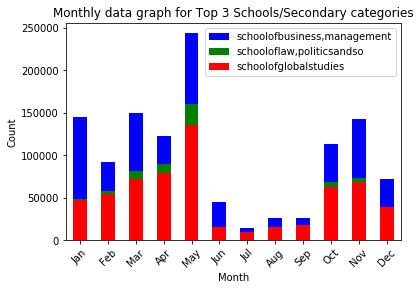

In [19]:
colors=['b','g','r', 'y', 'k']
for i in range(3):
    df3=df.loc[df['Category31']==top_3categories[i]]
    df3.groupby(df3.index.month).count()['Category31'].plot(label=top_3categories[i],kind = "bar", color=colors[i])
plt.legend()
plt.xticks(rotation=45)
plt.xticks(np.arange(12), ('Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly data graph for Top 3 Schools/Secondary categories')
plt.show()

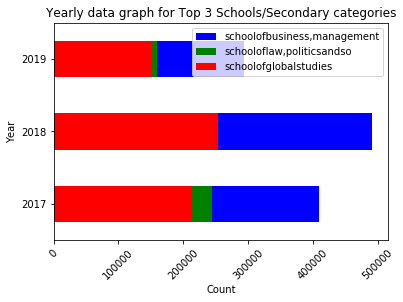

In [20]:

for i in range(3):
    df3=df.loc[df['Category31']==top_3categories[i]]
    df3.groupby(df3.index.year).count()['Category31'].plot(label=top_3categories[i],kind = "barh", color=colors[i])
plt.xticks(rotation=45)
plt.legend()
plt.xlabel('Count')
plt.ylabel('Year')
plt.title('Yearly data graph for Top 3 Schools/Secondary categories')
plt.show()

In [21]:
spent_times=[]
for i in range(len(uni_category)):
    vs=0
    df1=df.loc[df['Category11']==uni_category[i]]
    sflag=0
    for k in range(len(df1)):
        if(df1['Direction'].values[k]=='I'):
            if(sflag==0):
                sflag=1
                st=df1.index.values[k]
            elif(k==0):
                if(sflag==1):
                    et=df1.index.values[k]
                    dis=et-st
                    vs+=dis/np.timedelta64(1, 'h')
                continue
        else:
            if(sflag==1):
                et=df1.index.values[k]
                dis=et-st
                vs+=dis/np.timedelta64(1, 'h')
                sflag=0
    spent_times.append(vs)
print(spent_times)              

[8018.87972222295, 7541.259166666332, 6482.528333333349, 1074.1472222222224, 501.4411111111114, 4275.254722222222, 335.4233333333334, 92.80944444444445, 5386.945833333328, 3773.423611111115, 680.3833333333339, 6503.838333333289, 359.22944444444494, 0, 1.915, 37.70611111111111, 24.491944444444442, 6.821944444444444]


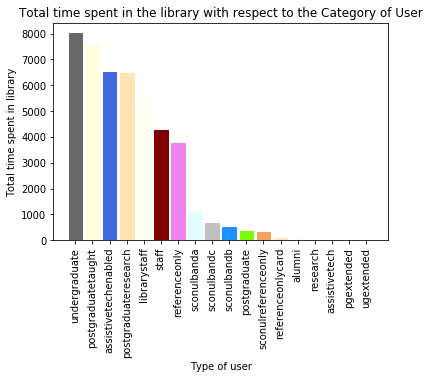

In [22]:
import matplotlib.colors as pltc
from random import sample
all_colors = [k for k,v in pltc.cnames.items()]
colors = sample(all_colors, len(spent_times))
spent_times=np.array(spent_times)
indexes1=np.argsort(spent_times)
barlist=plt.bar(np.arange(len(spent_times)),spent_times[indexes1][::-1])
for i in range(len(colors)):
    barlist[i].set_color(colors[i])
plt.xticks(rotation=90)
plt.xticks(np.arange(len(spent_times)),uni_category[indexes1][::-1] )
plt.title('Total time spent in the library with respect to the Category of User')
plt.xlabel('Type of user')
plt.ylabel('Total time spent in library')
plt.show()

In [23]:
spent_times3=[]
for i in range(len(uni_category3)):
    vs=0
    df1=df.loc[df['Category31']==uni_category3[i]]
    sflag=0
    for k in range(len(df1)):
        if(df1['Direction'].values[k]=='I'):
            if(sflag==0):
                sflag=1
                st=df1.index.values[k]
            elif(k==0):
                if(sflag==1):
                    et=df1.index.values[k]
                    dis=et-st
                    vs+=dis/np.timedelta64(1, 'h')
                continue
        else:
            if(sflag==1):
                et=df1.index.values[k]
                dis=et-st
                vs+=dis/np.timedelta64(1, 'h')
                sflag=0
    spent_times3.append(vs)

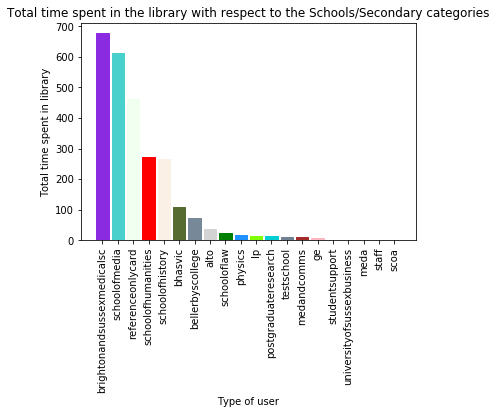

In [24]:
spent_times3=np.array(spent_times3)
indexes=np.argsort(spent_times3)
indexes=indexes[:20]
all_colors = [k for k,v in pltc.cnames.items()]
colors = sample(all_colors, len(indexes))
barlist=plt.bar(np.arange(len(indexes)),spent_times3[indexes][::-1])
for i in range(len(colors)):
    barlist[i].set_color(colors[i])
plt.xticks(rotation=90)
plt.xticks(np.arange(len(indexes)),uni_category3[indexes][::-1] )
plt.title('Total time spent in the library with respect to the Schools/Secondary categories')
plt.xlabel('Type of user')
plt.ylabel('Total time spent in library')
plt.show()

## Predictive Modelling

In [25]:
top_category=uni_category[indexes1[-1]]
df1=df.loc[df['Category11']==top_category]
df_top=df1.loc[df1['Direction']=='I']

In [26]:
daily_data=df_top.groupby(df_top.index.date).count()['Category1']

In [27]:
# fit model

X = daily_data.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]

In [28]:
import warnings
warnings.filterwarnings("ignore")
history =[x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
error = mean_squared_error(test, predictions)
ARIMA_RMSE=np.sqrt(error)
print('ARIMA MSE: %.3f' % ARIMA_RMSE)

ARIMA MSE: 864.782


In [29]:
all_predict=np.concatenate([np.array(train),  np.array(predictions).ravel()])
dates=[x.strftime("%d-%b-%Y") for x in daily_data.index]

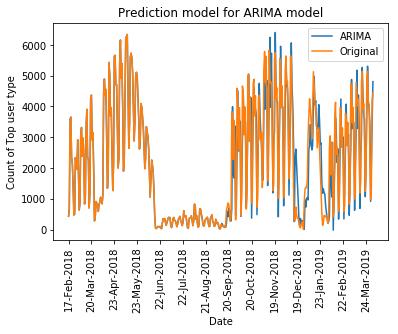

In [30]:
plt.plot(all_predict[len(train)-200:len(train)+200],label='ARIMA')
plt.plot(history[len(train)-200:len(train)+200],label='Original')
plt.xticks(rotation=90)
plt.title('Prediction model for ARIMA model')
plt.xlabel('Date')
plt.ylabel('Count of Top user type')
plt.xticks(np.arange(0,400,30),[dates[x] for x in np.arange(len(train)-200, len(train)+200, 30)])
plt.legend()
plt.show()

In [31]:
import warnings
warnings.filterwarnings("ignore")
history =[x for x in train]
predictions1 = list()
for t in range(len(test)):
	model = sm.tsa.statespace.SARIMAX(history,order=(5,1,0),seasonal_order=(3,1,1,1),
                                enforce_stationarity=False, enforce_invertibility=False)
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions1.append(yhat)
	obs = test[t]
	history.append(obs)
error = mean_squared_error(test, predictions1)
SARIMA_RMSE=np.sqrt(error)
print('SARIMA RMSE: %.3f' % SARIMA_RMSE)

SARIMA RMSE: 698.468


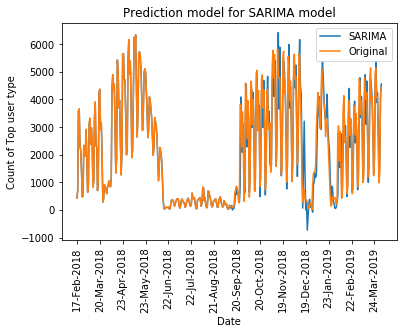

In [32]:
all_predict1=np.concatenate([np.array(train),  np.array(predictions1).ravel()])
plt.plot(all_predict1[len(train)-200:len(train)+200],label='SARIMA')
plt.plot(history[len(train)-200:len(train)+200],label='Original')
plt.xticks(rotation=90)
plt.title('Prediction model for SARIMA model')
plt.xlabel('Date')
plt.ylabel('Count of Top user type')
plt.xticks(np.arange(0,400,30),[dates[x] for x in np.arange(len(train)-200, len(train)+200, 30)])
plt.legend()
plt.show()

In [33]:
from sklearn.ensemble.forest import RandomForestRegressor
RF_Model = RandomForestRegressor(n_estimators=100,
                                 max_features=1, oob_score=True)
rgr=RF_Model.fit(train[0:len(train)-1].reshape(-1, 1), train[1:].reshape(-1, 1))

In [34]:
predict_RF=rgr.predict(X[len(train):len(train)+200].reshape(-1, 1))
error = mean_squared_error(test[:200], predict_RF)
RF_RMSE=np.sqrt(error)
print('RF RMSE: %.3f' % RF_RMSE)

RF RMSE: 757.916


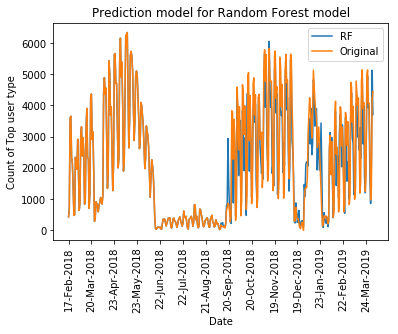

In [35]:
all_predict1=np.concatenate([np.array(train),  np.array(predict_RF).ravel()])
plt.plot(all_predict1[len(train)-200:len(train)+200],label='RF')
plt.plot(X[len(train)-200:len(train)+200],label='Original')
plt.xticks(rotation=90)
plt.title('Prediction model for Random Forest model')
plt.xlabel('Date')
plt.ylabel('Count of Top user type')
plt.xticks(np.arange(0,400,30),[dates[x] for x in np.arange(len(train)-200, len(train)+200, 30)])
plt.legend()
plt.show()